# Fundamentals (POSTPONED)
The fundamentals that I want are:
* Easy to get:
    * Company headquarters location
    * Sector
    * Outstanding shares (for market cap, want weekly)
    * Earnings yield (inverse of P/E)
    * Cash & equivalents (for dilution prediction)
    * Cash burn (for dilution prediction, but must be estimated)

* Hard to get:
    * Free float (outstanding - insider - institutional)

* Very hard to get:
    * Short interest

A list of what I have found:
* [Polygon](https://polygon.io/docs/stocks/get_vx_reference_financials): has all easy to get, but not for ADRs
* [Finnhub](https://finnhub.io/docs/api): has all easy to get data, but not for delisted stocks
* [FinancialModelingPrep](https://site.financialmodelingprep.com/): has all easy to get. Free float can be calculated as they have insider/institutional holdings and outstanding shares.
* [Valueinvesting.io](https://valueinvesting.io/short-interest-api): only has short-interest but nothing else, Either 100 or 400/month.
* Compustat: I have access through my university, but not sure if short-interest is available
* [Sharadar](https://data.nasdaq.com/search?filters=%5B%22Equities%22%2C%22Fundamentals%22%5D): Listed on the Nasdaq Data Link data market
* [Tiingo](https://www.tiingo.com/documentation/)
* [IEXCloud](https://iexcloud.io/)
* [EODHD](https://eodhd.com/pricing?utm_source=google_search&utm_medium=cpc&utm_campaign=Brand_Europe&roistat_referrer&roistat_pos&roistat=google1_g_124657464434_526148784701_eodhd&gad=1)

Since Sharadar has almost everything I want, including data for ADRs, I settle with them. QuantRocket also uses them. I thought they are extremely expensive so I didn't look further. Turns out I am wrong, but it's still stupid you have to create an account just to see the pricing. The bundle for all data is 69/month. And they have a bulk data download endpoint. Although they do not provide float, it can be calculated by subtracting the institutional and insider ownership from the outstanding shares. While this is not 100% correct (e.g. you also have to take into account options, Rule 144 etc.) it is good enough for my purposes.

Almost no one has short interest. I will likely settle with Compustat and Valueinvesting.io for that. However this is not high on my priorities list.

Other alternative data that I want are the historical borrowing rates on IBKR. These can be bought on [iborrowdesk.com](https://www.patreon.com/iborrowdesk) for almost free.


In [1]:
from datetime import datetime, date, time, timedelta
from utils import get_tickers, first_trading_date_after_equal, last_trading_date_before_equal
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import nasdaqdatalink

START_DATE = first_trading_date_after_equal(datetime(2021, 1, 1).date())
END_DATE = last_trading_date_before_equal(datetime(2023, 8, 18).date())
print(START_DATE)
print(END_DATE)

POLYGON_DATA_PATH = "../../../data/polygon/"
SHARADAR_DATA_PATH = "../../../data/sharadar/"

nasdaqdatalink.read_key(filename=SHARADAR_DATA_PATH + "secret.txt")

2021-01-04
2023-08-18


Polygon actually does not have all tickers. They probably don't have ADRs because their filings are a little bit different.

In [2]:
from polygon.rest import RESTClient

with open(POLYGON_DATA_PATH + "secret.txt") as f:
    KEY = next(f).strip()

client = RESTClient(api_key=KEY)

data = pd.DataFrame(client.vx.list_stock_financials(cik = 1848275, filing_date_gte=START_DATE, filing_date_lte=END_DATE) )
print(data)
data = client.get_ticker_details(ticker="TOP", date=END_DATE)
print(data)

Empty DataFrame
Columns: []
Index: []
TickerDetails(active=True, address=None, branding=Branding(icon_url=None, logo_url=None, accent_color=None, light_color=None, dark_color=None), cik='0001848275', composite_figi=None, currency_name='usd', currency_symbol=None, base_currency_name=None, base_currency_symbol=None, delisted_utc=None, description='TOP Financial Group Ltd is an online brokerage firm in Hong Kong specializing in the trading of local and overseas equities, futures, and options products. The company operates in only one segment which is the futures brokerage service.', ticker_root='TOP', ticker_suffix=None, homepage_url='https://www.zyfgl.com', list_date='2022-06-01', locale='us', market='stocks', market_cap=219845423.24, name='TOP Financial Group Limited Ordinary Shares', phone_number=None, primary_exchange='XNAS', share_class_figi=None, share_class_shares_outstanding=35010000, sic_code=None, sic_description=None, ticker='TOP', total_employees=11, type='CS', weighted_shares

# Sharadar Core US Fundamentals
They offer several subscriptions. They have data for fundamentals (59/month), insiders (25/month), institutional ownership (25/month) and EOD prices (29/month). The bundle that contains these all only costs 69/month. So I might as well pay the 10/month more.

Using this API is a little bit different than others. This is because Sharadar sells their data through the Nasdaq Data Link (NDL), so they must use their API. This API must be usable for all vendors, so the API endpoints are very generalized. They have 4 different APIs. The one we need is the 'REST API for tables data' for data product code SF1. 

Every data set that uses the tables API has different sets of tables. E.g. for Sharadar the tables are SF1, DAILY, TICKERS, INDICATORS, ACTIONS, SP500 and EVENTS. All data is stored in either one of these tables. Then in the API call filters (e.g. <code>ticker='AAPL'</code>) are used to narrow down the selection. The return value is XML, JSON or CSV. The filters available depend on the data set. For SF1 these are ticker, calendardate, lastupdated, dimension and datekey. You can also append the filter with [filter operators](https://docs.data.nasdaq.com/docs/parameters-1), such as <code>.gt</code> to return only the rows with values greater than the specified value. We can also pass several parameters to each call, such as <code>qopts.columns</code> to select which column of the table we want. There are also options to bulk download. 

The 'dimension' must be a 3-letter combination of (AR, MR) and (Y, T, Q). AR is As-Reported, MR is Most-Recent, Y is for annual data while T is for trailing-12-month and Q is for quarterly. Q is not available for ADRs. The AR is the one that excludes restatements. Sometimes when companies file annual reports, they do not file a quarterly one because that information is already contained in the annual. If a restatement occurs in ART within the 12-month period, that datapoint is restated.

Which one do we need? The best point-in-time information is ART. We definitely need As-Reported. Also a trailing-12-month figure makes more sense. If we did not use 12-month trailing we would use either quarterly (which has no information about the previous 3 quarters) or annual (which has no information of the most recent months unless we query by January). ART *does* include restatements, but only if it was available within the 12-month period. We want restatements, but not those that we would not have access to at that point in time. So ART is the best choice.

So the goal is: build a fundamental database for as many tickers as possible in our <code>tickers_v3</code> ticker list (excluding ETF and ETNs). This database has a quarterly frequency which contains the information of the last 12 months. Except for ADRs because they do not file annually. We do not need all ratio's, just a few. Some data is non-changing, such as the country or sector, which will be added to our ticker list to create <code>tickers_v4</code>. Some data updates more frequently than once per quarter. These are the ratios that depend on price such as P/B ratio. For these we only store the non-price (B) part. Then at backtesting the true value is calculated. Apparently Sharadar fundamentals are split-adjusted.

We will add to <code>tickers_v4</code>:
* Sector (not the SIC sector)
* Industry
* Country

We will add to <code>raw/fundamentals/AAA.csv</code>:
* date: datekey: Date of availability (date)
* fiscal_period: calendardate: The rounded up fiscal period. This is for easy comparison across companies. And also better for graphing fundamentals across time. Else the quarters may not be exact.

* shares_outstanding: sharesbas * sharefactor. Sharefactor is used to adjust for stocks that have multiple classes (like BRK.A and BRK.B). Sharadar gets the marketcap by multiplying shares_outstanding with the price to get the market cap.

* cash: cashnequsd : Cash and Equivalents (USD)
* change in cash: cashnequsd / previous cashnequ
* current_ratio: currentratio : Short term assets/liabilities (ratio). Higher is better.

* div_ps: dps: Dividends per share (USD/share)
* earnings_ps: epsusd : to calculate P/E (USD)
* book_ps: bvps/fxusd: book value per share (may not be USD) converted to USD
* sales_ps : sps: sales per share (USD)
* net_margin: netmargin: Net margin (ratio)

Other data we want:
* S&P500 constituents in <code>raw/SP500.csv</code>. They do not have other indices. But for the other ones we can just construct them ourselves. Some are also mechanical unlike the S&P500.

This list is quite short. But it is enough to work with. We can easily add more if we want. We also have to take into account splits... The earnings per share gets halved with a 1-to-2 split. But some ratios stay the same such as the current ratio.

Also we will save the entire database just in case we need it later.

To not have to deal with naked API requests, we use the their official [SDK](https://github.com/Nasdaq/data-link-python/#local-api-key-environment-variable). Read their [quickstart guide](https://github.com/Nasdaq/data-link-python/blob/main/FOR_ANALYSTS.md) and [detailed guide](https://github.com/Nasdaq/data-link-python/blob/main/FOR_DEVELOPERS.md). It is really confusing what the difference between <code>get</code>, <code>get_table</code>, <code>DataSet</code>, <code>DataTable</code> and <code>DataBase</code> is. I will just follow the [examples](https://data.nasdaq.com/databases/SF1/documentation) and use <code>get_table</code>.

## 2.0 Downloading everything
Initially I wanted to do a request per ticker, but it is easier to just bulk download everything because the file isn't that big. I downloaded it using the browser link and then converted to parquet files, which are much smaller and much faster to load.

In [ ]:
for i in [1, 2, 3]:
    file = pd.read_csv(f"../../../data/sharadar/raw/SF{i}.csv", parse_dates=True)
    file.to_parquet(f"../../../data/sharadar/raw/SF{i}.parquet",  engine="pyarrow")

## 2.1 Getting all tickers
First get the list of tickers. This is unfortunately different from the Polygon one. The Polygon one is the most 'point-in-time' one: it does include old recycled tickers. Sharadar does not. But even if it was we would expect some small differences between data vendors.

In [3]:
ticker_metadata = nasdaqdatalink.get_table('SHARADAR/TICKERS', table='SF1', paginate=True)
# ticker_metadata.iloc[:, :10]
ticker_metadata["cik"] = ticker_metadata["secfilings"].str[-10:].astype(int)
ticker_metadata.to_csv(SHARADAR_DATA_PATH + 'raw/tickers.csv')
ticker_metadata[ticker_metadata["ticker"] == "META"].head(3)

,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,...,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite,cik
None,,,,,,,,,,,,,,,,,,,,,
5452,SF1,194817,META,META PLATFORMS INC,NASDAQ,N,Domestic Common Stock,30303M102,7370,Services,...,California; U.S.A,2023-07-27,2014-09-26,2012-05-18,2023-09-11,2010-12-31,2023-06-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://investor.fb.com,1326801


In [23]:
def get_tickers_sharadar():
    """
    Retrieves the ticker list from Sharadar.
    """
    tickers = pd.read_csv(SHARADAR_DATA_PATH + 'raw/tickers.csv')
    tickers["lastupdated"] = pd.to_datetime(tickers["lastupdated"]).dt.date
    tickers["firstadded"] = pd.to_datetime(tickers["firstadded"]).dt.date
    tickers["firstpricedate"] = pd.to_datetime(tickers["firstpricedate"]).dt.date
    tickers["lastpricedate"] = pd.to_datetime(tickers["lastpricedate"]).dt.date
    tickers["firstquarter"] = pd.to_datetime(tickers["firstquarter"]).dt.date
    tickers["lastquarter"] = pd.to_datetime(tickers["lastquarter"]).dt.date
    return tickers

Second, get the list of definitions used in the fundamentals. These can also be found [here](https://docs-1-8--quantrocket.netlify.app/docs/data/fundamental/sharadar/).

The ones that need more attention are the dates. 
* <code>datekey</code> is the date of the filing, but only for as-reported. For most-recent this is equal to the reportperiod and thus this field is useless. We can safely assume that this information was available one day after the datekey. This is also the date that is used to get ratios such as P/E. This is the one we need.
* <code>reportperiod</code> is the end of the fiscal period. So <code>datekey</code> will always be later than this one. 
* <code>calendardate</code> is the <code>reportperiod</code>, but rounded 'up' such that it is easier to compare fundamentals across companies. For example if the fiscal ending period is 2022-12-15, then the <code>calendardate</code> is 2022-12-31. 

In [4]:
columns = nasdaqdatalink.get_table('SHARADAR/INDICATORS', table='SF1')
columns.to_csv(SHARADAR_DATA_PATH + "raw/SF1_definitions.csv")
columns.head(3)

,table,indicator,isfilter,isprimarykey,title,description,unittype
None,,,,,,,
0,SF1,workingcapital,N,N,Working Capital,[Metrics] Working capital measures the differe...,currency
1,SF1,ticker,Y,Y,Ticker Symbol,[Entity] The ticker is a unique identifier for...,text
2,SF1,tbvps,N,N,Tangible Assets Book Value per Share,[Metrics] Measures the ratio between [Tangible...,currency/share


Exploring this table in Excel, we find that it does not have recycled tickers (NXU, GOLD). It also does not have renamed tickers (FB, ABX). The renamed tickers is not that of a big problem, using the Polygon ticker list I can get a list of renamings by comparing ciks. But not having recycled tickers means the further back in time I go, the less accurate the fundamental database gets. Even though the database contains delisted stocks. 

However, I will just accept this fact. The amount of recycled tickers is low. The most important thing is that (non-recycled) delisted stocks are included. It is good enough. There is no need to get to 100% accuracy, as I am not primarily interested in fundamental strategies. My sample size is too low for that anyways and I would just use CRSP for that. And these fundamental strategies are already researched into oblivion.

For any diversified strategy this <0.5% of missing fundamentals also not matter too much. In almost 3 years of data, there were only around 20 of such cases. Only the original have data, so we miss 10. However, for price data these are included. Just not for fundamentals. If I really wanted, I could get these fundamentals manually from the SEC files themselves or using other APIs. But I am not going to bother with it now, it is on the to do list.

By chance while exploring the ticker list in Excel, I noticed that the cik is actually available, hidden in the link to the SEC files. This takes care of the renaming problem, now I can just look up the cik in the polygon table. For tickers that do not have cik, the ticker is used.

## 2.2 Differences in 'dimension'
Let's see how the A, Q and T works. How is EPS calculated for the three? Is the 12-month trailing a sum? If it is a sum, how is cashneq calculated? Because for that metric it does not make sense to take a sum. Depending on the answers we may need to change our approach and use Q/A instead of T.

(The free subscription only has data for MRY (so annual, most-recent) for a small selection of stocks, so here I got a premium subscription.)

In [11]:
def convert_raw_fundamentals(df):
    '''
    Convert the raw dataset from Sharadar to our preferred format.
    '''
    # Get only the columns we need
    df = df[['datekey', 'calendardate', 'sharesbas', 'sharefactor', 'cashnequsd', 'currentratio', 'dps', 'epsusd', 'bvps', 'sps', 'netmargin', 'fxusd']]

    # Get shares outstanding, then the book value per share in USD.
    df['sharesbas_x_sharefactor'] = df['sharesbas'] * df['sharefactor']
    df['bvps_d_fxusd'] = df['bvps'] / df['fxusd']

    # Rename to snake_case
    df = df.rename(columns={'datekey': 'date', 'calendardate': 'fiscal_period', 'sharesbas_x_sharefactor': 'shares_outstanding', 'cashnequsd':'cash', 'currentratio':'current_ratio', 'dps':'div_ps', 'epsusd':'earnings_ps', 'bvps_d_fxusd': 'book_ps', 'sps':'sales_ps', 'netmargin':'net_margin'})

    df.sort_values(by='date', inplace=True)
    
    df['fiscal_period'] = pd.to_datetime(df['fiscal_period']).dt.date
    df['date'] = pd.to_datetime(df['date']).dt.date

    df = df.reset_index(drop=True)
    # Drop unnecessary columns
    return df[['date', 'fiscal_period', 'shares_outstanding', 'cash', 'current_ratio', 'div_ps', 'earnings_ps', 'book_ps', 'sales_ps', 'net_margin']]

In [12]:
data_yearly = convert_raw_fundamentals(nasdaqdatalink.get_table('SHARADAR/SF1', ticker='TSLA', dimension='ARY', datekey={'gte':'2020-01-01', 'lte':'2023-06-01'}) )
print(data_yearly.shape)
data_yearly

(4, 10)


,date,fiscal_period,shares_outstanding,cash,current_ratio,div_ps,earnings_ps,book_ps,sales_ps,net_margin
0,2020-02-13,2019-12-31,2.720124e+09,6514000000,1.135,0.0,-0.328,2.493,9.257,-0.035
1,2021-02-08,2020-12-31,2.879561e+09,19384000000,1.875,0.0,0.247,7.940,11.267,0.023
2,2022-02-07,2021-12-31,3.100523e+09,17576000000,1.375,0.0,1.867,10.206,18.196,0.103
3,2023-01-31,2022-12-31,3.164103e+09,16253000000,1.532,0.0,4.020,14.282,26.026,0.154


In [13]:
data_quarterly = convert_raw_fundamentals(nasdaqdatalink.get_table('SHARADAR/SF1', ticker='TSLA', dimension='ARQ', datekey={'gte':'2020-01-01', 'lte':'2023-06-01'}) )
print(data_quarterly.shape)
data_quarterly.head(5)

(14, 10)


,date,fiscal_period,shares_outstanding,cash,current_ratio,div_ps,earnings_ps,book_ps,sales_ps,net_margin
0,2020-02-13,2019-12-31,2.720124e+09,6514000000,1.135,0.0,0.041,2.451,2.735,0.014
1,2020-04-30,2020-03-31,2.780567e+09,8080000000,1.243,0.0,0.006,3.342,2.180,0.003
2,2020-07-28,2020-06-30,2.795426e+09,8615000000,1.250,0.0,0.037,3.532,2.163,0.017
3,2020-10-26,2020-09-30,2.843702e+09,14531000000,1.635,0.0,0.107,5.703,3.120,0.038
4,2021-02-08,2020-12-31,2.879561e+09,19384000000,1.875,0.0,0.097,7.790,3.766,0.025


In [5]:
data_trailing = convert_raw_fundamentals(nasdaqdatalink.get_table('SHARADAR/SF1', ticker='TSLA', dimension='ART', datekey={'gte':'2020-01-01', 'lte':'2023-06-01'}) )
print(data_trailing.shape)
data_trailing.head(5)

(14, 10)


,date,fiscal_period,shares_outstanding,cash,current_ratio,div_ps,earnings_ps,book_ps,sales_ps,net_margin
None,,,,,,,,,,
13,2020-02-13,2019-12-31,2.720124e+09,6514000000,1.135,0.0,-0.328,2.493,9.257,-0.035
12,2020-04-30,2020-03-31,2.780567e+09,8080000000,1.243,0.0,-0.053,3.342,9.480,-0.006
11,2020-07-28,2020-06-30,2.795426e+09,8615000000,1.250,0.0,0.138,3.532,9.214,0.014
10,2020-10-26,2020-09-30,2.843702e+09,14531000000,1.635,0.0,0.191,5.703,10.023,0.020
9,2021-02-08,2020-12-31,2.879561e+09,19384000000,1.875,0.0,0.247,7.940,11.267,0.023


Text(0.5, 1.0, 'TSLA EPS')

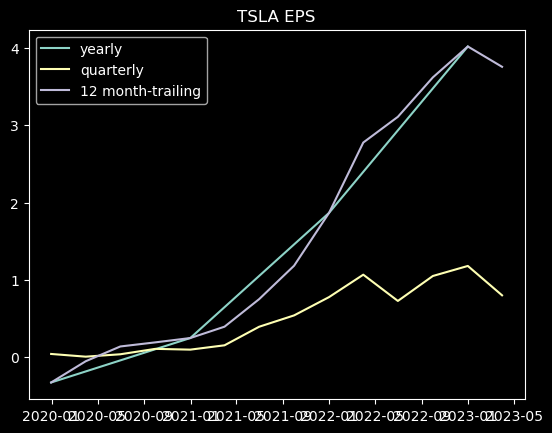

In [14]:
plt.style.use('dark_background')
fig, ax = plt.subplots()
ax.plot(data_yearly['fiscal_period'], data_yearly['earnings_ps'], label='yearly')
ax.plot(data_quarterly['fiscal_period'], data_quarterly['earnings_ps'], label='quarterly')
ax.plot(data_trailing['fiscal_period'], data_trailing['earnings_ps'], label='12 month-trailing')
ax.legend()
ax.set_title('TSLA EPS')

## 2.3 I hate splits
Apparently this data is already adjusted, which I do not like. Also, the data is *only* adjusted for splits. Remember: our goal is to eventually get value or other metrics in *ratios*. The exact EPS does not matter. Only P/E. The problems:
1. Calculating certain metrics becomes more annoying: the original plan to get the market cap was shares_outstanding * close_original, which is very simple. If shares_outstanding is adjusted for splits, I need to calculate shares_outstanding * close_adjusted, where close_adjusted is only adjusted for splits. In this case we need the entire split-adjusted but not-dividend-adjusted price series. Easier is shares_outstanding * split_factor * close_original. This also applies to the earnings_ps and other price metrics. To get a P/E ratio, the split-only-adjusted price needs to be divided by the earnings_ps. This is because the earnings_ps is only split-adjusted. 
2. If our split database is up to date to 2023-01-01, but the Sharadar is up to date to 2024-01-01, problems start to appear. This is because we do not have the splits from 2023-01-01 to 2024-01-01. However the Sharadar fundamentals is *always* adjusted until the most recent date (in this example 2024), whether we want it or not. Make sure the downloaded Polygon split data covers what we have in the Sharadar database.
3. If we want to use both Polygon and Sharadar for fundamentals to fill in the last 3% of missing fundamental data, the two are now out of sync. Polygons data is point-in-time unadjusted. Sharadar is not. We will have to adjust one or the other.

Choices:
1. Convert Sharadar fundamentals to point-in-time unadjusted. Then we can just do shares_outstanding * close_original.
2. Keep the Sharadar fundamentals as-is, but during calculation of market cap, we have to use the split factor or a split-only adjusted price series. Obviously keeping the split-only price series is inefficient so we won't do that.
3. Converting fundamentals to split-and-dividend adjusted. But if you think about it, it does not make sense. The metrics lose their interpretation. Example: the marketcap is simply the amount of shares. If a stock is $1 and has outstanding shares of 100k and on day 2 the stock does a 1-to-2 split the stock is now $0.50. The outstanding shares become 200k. However if on day 3 the stock pays a 50% dividend the stock also drops 50%. The outstanding shares is *still* 200k. If we would adjust for dividends, the outstanding shares on day 2 would not be 200k anymore. As the other metrics like P/E are based on the outstanding shares, everything breaks.

I want both. It should be easy to get the point-in-time marketcap and also compare across time. I will store them in the folders 'adjusted' and 'unadjusted'. These are both in the processed folder. (Remember: the processed folder is not necessarily adjusted, but just usable to the backtester. Raw data is the downloaded version without too much manipulation, except maybe to get the correct format.)

How do you get the *unadjusted* version? We also only need to unadjust the metrics that are based off outstanding shares. These are e.g. earnings/share, dividend/share etc. The current_ratio e.g. is split-agnostic, it does not depend on outstanding shares. 

If a 1-to-2 split occurs, the stock was X2 before the split. And the outstanding shares was half before the split. If profits are the same, the EPS is X2 before the split. Considering multiple splits: if at day 5 a 1-to-2 split occurs and at day 10 a 1-to-3, then metrics from day 1 to 4 need to be adjusted by X6, and 5 to 9 by X3.

In [9]:
# Example on TSLA
adjustments = pd.read_csv(POLYGON_DATA_PATH + "raw/adjustments/TSLA-2020-01-04.csv")
adjustments['date'] = pd.to_datetime(adjustments['date']).dt.date # For some reason parse_dates=True does not work on dates.
adjustments['cumulative_adjustment'] = adjustments['amount'][::-1].cumprod()
adjustments

,ticker,date,type,subtype,amount,cumulative_adjustment
0,TSLA,2020-08-31,SPLIT,N,0.200000,0.066667
1,TSLA,2022-08-25,SPLIT,N,0.333333,0.333333


In [10]:
fundamentals_adjusted = pd.read_csv(SHARADAR_DATA_PATH + 'raw/TSLA_ART.csv')
fundamentals_adjusted['fiscal_period'] = pd.to_datetime(fundamentals_adjusted['fiscal_period']).dt.date
fundamentals_adjusted['date'] = pd.to_datetime(fundamentals_adjusted['date']).dt.date
fundamentals_adjusted

,date,fiscal_period,shares_outstanding,cash,current_ratio,div_ps,earnings_ps,book_ps,sales_ps,net_margin
0,2020-02-13,2019-12-31,2.720124e+09,6514000000,1.135,0.0,-0.328,2.493,9.257,-0.035
1,2020-04-30,2020-03-31,2.780567e+09,8080000000,1.243,0.0,-0.053,3.342,9.480,-0.006
2,2020-07-28,2020-06-30,2.795426e+09,8615000000,1.250,0.0,0.138,3.532,9.214,0.014
3,2020-10-26,2020-09-30,2.843702e+09,14531000000,1.635,0.0,0.191,5.703,10.023,0.020
4,2021-02-08,2020-12-31,2.879561e+09,19384000000,1.875,0.0,0.247,7.940,11.267,0.023
5,2021-04-28,2021-03-31,2.889991e+09,17141000000,1.661,0.0,0.394,7.984,12.466,0.032
6,2021-07-27,2021-06-30,2.970045e+09,16229000000,1.508,0.0,0.750,8.515,14.371,0.052
7,2021-10-25,2021-09-30,3.012795e+09,16065000000,1.385,0.0,1.183,9.036,15.647,0.074
8,2022-02-07,2021-12-31,3.100523e+09,17576000000,1.375,0.0,1.867,10.206,18.196,0.103
9,2022-04-25,2022-03-31,3.108030e+09,17505000000,1.354,0.0,2.777,10.988,20.048,0.135


Shares_outstanding must be divided by 3 and the _ps ratios multiplied by 3 if the date is between and including 2020-08-31 and 2022-08-24. Why not 25? Because if the split happens on 08-25, the price drop happens between the close of 08-24 and 08-25. To adjust the price drop, we need to bring the prices down (and hence marketcap) from 08-24 and earlier. Not from 08-25. 

In [11]:
# Create helper column. The interpretation of cumulative_adjustments, is that at 2020-08-31, 0.06667 shares is now 1 share. If the EPS is now $1/share, in 2020 that would have been $1/0.0667=$15/share.
adjustments['date_prev'] = adjustments['date'].shift(1)
adjustments['date_prev'].fillna(datetime.min.date(), inplace=True)
adjustments

,ticker,date,type,subtype,amount,cumulative_adjustment,date_prev
0,TSLA,2020-08-31,SPLIT,N,0.200000,0.066667,0001-01-01
1,TSLA,2022-08-25,SPLIT,N,0.333333,0.333333,2020-08-31


In [133]:
# No adjustments if 2022-08-25 or later
date_ = date(2022, 8, 25)
adjustments[(date_ >= adjustments['date_prev']) & (date_ < adjustments['date'])]

,ticker,date,type,subtype,amount,cumulative_adjustment,date_prev


In [134]:
# Adjust X3 of /3 between the two splits
date_ = date(2022, 8, 20)
adjustments[(date_ >= adjustments['date_prev']) & (date_ < adjustments['date'])]

,ticker,date,type,subtype,amount,cumulative_adjustment,date_prev
1,TSLA,2022-08-25,SPLIT,N,0.333333,0.333333,2020-08-31


In [135]:
# Adjust X15 of /15 before the first split
date_ = date(2020, 8, 20)
adjustments[(date_ >= adjustments['date_prev']) & (date_ < adjustments['date'])]

,ticker,date,type,subtype,amount,cumulative_adjustment,date_prev
0,TSLA,2020-08-31,SPLIT,N,0.2,0.066667,0001-01-01


In [15]:
def unadjust_fundamentals(fundamentals_adjusted, adjustments):
    """
    Undoes the split adjustment of fundamentals in the Sharadar data set.
        fundamentals : DataFrame, uses the output of convert_raw_fundamentals
        splits: the split dataset as in the polygon/raw/adjustments
    """
    # Get the splits
    adjustments['date'] = pd.to_datetime(adjustments['date']).dt.date
    adjustments['cumulative_adjustment'] = adjustments['amount'][::-1].cumprod()
    adjustments['date_prev'] = adjustments['date'].shift(1)
    adjustments['date_prev'].fillna(datetime.min.date(), inplace=True)

    # Get dates in datetime.date
    fundamentals_adjusted['fiscal_period'] = pd.to_datetime(fundamentals_adjusted['fiscal_period']).dt.date
    fundamentals_adjusted['date'] = pd.to_datetime(fundamentals_adjusted['date']).dt.date

    fundamentals_unadjusted = fundamentals_adjusted.copy()
    if not adjustments.empty:
        for _, row in adjustments.iterrows():
            start_date_split = row['date_prev']
            end_date_split = row['date']
            cumulative_adjustment = row['cumulative_adjustment']

            # If dates are between the split dates, adjust the metrics
                # Some metrics need to be multiplied (shares outstanding)
            fundamentals_unadjusted.loc[(fundamentals_unadjusted['date'] >= start_date_split) & (fundamentals_unadjusted['date'] < end_date_split), ['shares_outstanding']] = fundamentals_unadjusted.shares_outstanding * cumulative_adjustment
                # Some divided (EPS)
            fundamentals_unadjusted.loc[(fundamentals_unadjusted['date'] >= start_date_split) & (fundamentals_unadjusted['date'] < end_date_split), ['div_ps', 'book_ps', 'sales_ps']] = fundamentals_unadjusted[['div_ps', 'book_ps', 'sales_ps']] / cumulative_adjustment

    return fundamentals_unadjusted

In [18]:
adjustments = pd.read_csv(POLYGON_DATA_PATH + "raw/adjustments/TSLA-2020-01-04.csv")
fundamentals = convert_raw_fundamentals(nasdaqdatalink.get_table('SHARADAR/SF1', ticker='TSLA', dimension='ART', datekey={'gte':'2020-01-01', 'lte':'2023-06-01'}) )
fundamentals_unadjusted = unadjust_fundamentals(fundamentals, adjustments)
fundamentals_unadjusted

,date,fiscal_period,shares_outstanding,cash,current_ratio,div_ps,earnings_ps,book_ps,sales_ps,net_margin
0,2020-02-13,2019-12-31,1.813416e+08,6514000000,1.135,0.0,-0.328,37.395,138.855,-0.035
1,2020-04-30,2020-03-31,1.853711e+08,8080000000,1.243,0.0,-0.053,50.130,142.200,-0.006
2,2020-07-28,2020-06-30,1.863617e+08,8615000000,1.250,0.0,0.138,52.980,138.210,0.014
3,2020-10-26,2020-09-30,9.479007e+08,14531000000,1.635,0.0,0.191,17.109,30.069,0.020
4,2021-02-08,2020-12-31,9.598535e+08,19384000000,1.875,0.0,0.247,23.820,33.801,0.023
5,2021-04-28,2021-03-31,9.633304e+08,17141000000,1.661,0.0,0.394,23.952,37.398,0.032
6,2021-07-27,2021-06-30,9.900152e+08,16229000000,1.508,0.0,0.750,25.545,43.113,0.052
7,2021-10-25,2021-09-30,1.004265e+09,16065000000,1.385,0.0,1.183,27.108,46.941,0.074
8,2022-02-07,2021-12-31,1.033508e+09,17576000000,1.375,0.0,1.867,30.618,54.588,0.103
9,2022-04-25,2022-03-31,1.036010e+09,17505000000,1.354,0.0,2.777,32.964,60.144,0.135


Now let's get all fundamentals.

In [34]:
sharadar_tickers = get_tickers_sharadar()
sharadar_tickers = sharadar_tickers.sort_values(by='cik')
sharadar_tickers[sharadar_tickers['cik'].duplicated(keep=False)].head(5)

,None,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,...,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite,cik
2072,2072,SF1,199965,UNM,UNUM GROUP,NYSE,N,Domestic Common Stock Primary Class,91529Y106 903192102 743889206,6321,...,Tennessee; U.S.A,2023-08-02,2014-09-23,1986-11-06,2023-09-11,1995-12-31,2023-06-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.unum.com,5513
14677,14677,SF1,116169,PVT1,PROVIDENT COMPANIES INC,NYSE,Y,Domestic Common Stock,743862104,6321,...,Tennessee; U.S.A,2019-02-23,2018-07-21,1986-01-01,1999-06-30,1996-12-31,1999-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,5513
1928,1928,SF1,631666,AAMRQ,AMR CORP,NYSE,Y,Domestic Common Stock,001765106,4512,...,Texas; U.S.A,2021-08-25,2020-07-16,1986-01-01,2013-12-05,1996-12-31,2013-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,6201
2076,2076,SF1,199960,AAL,AMERICAN AIRLINES GROUP INC,NASDAQ,N,Domestic Common Stock,02376R102,4512,...,Texas; U.S.A,2023-07-20,2015-04-14,2013-12-09,2023-09-11,2012-12-31,2023-06-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.aa.com,6201
2085,2085,SF1,199949,SSINQ,STAGE STORES INC,NYSE,Y,Domestic Common Stock,85254C305,5651,...,Texas; U.S.A,2021-06-10,2014-10-10,2001-08-30,2020-05-08,1999-12-31,2019-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,6885


In [30]:
polygon_tickers = get_tickers_v3()
polygon_tickers.head()

,ID,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi,delisted_utc
0,A-2021-01-04,A,Agilent Technologies Inc.,True,2021-01-04,2023-08-18,2023-08-31,CS,1090872,BBG000C2V3D6,
1,AA-2021-01-04,AA,Alcoa Corporation,True,2021-01-04,2023-08-18,2023-09-01,CS,1675149,BBG00B3T3HD3,
2,AAC-2021-03-25,AAC,Ares Acquisition Corporation,True,2021-03-25,2023-08-18,2023-09-01,CS,1829432,,
3,AACG-2021-01-04,AACG,ATA Creativity Global American Depositary Shares,True,2021-01-04,2023-08-18,2023-09-01,ADRC,1420529,BBG000V2S3P6,
4,AACI-2021-11-10,AACI,Armada Acquisition Corp. I Common Stock,True,2021-11-10,2023-08-18,2023-09-01,CS,1844817,BBG011XR7306,


The problem is that Polygon has the point-in-time ticker and cik, while I can only query Sharadar fundamentals by last-known-ticker. So I have to loop through the ciks in tickers_v3 and get the ticker/cik and see what the last-known-ticker is in SF1 by looking up the cik in the Sharadar ticker list. However ciks can be duplicated. So there is no 1-to-1 mapping between tickers and ciks. 

NOTE: I went back to 1_get_tickers to get renamings to solve this issue. Also, comparing dates becomes an issue when the start_date and end_date in tickers_v3 has ghost days. So I will postpone getting fundamentals until I have at least daily data from Polygon.



In [36]:
# sharadar_tickers = get_tickers_sharadar()

# polygon_tickers = get_tickers_v3()
# polygon_tickers = polygon_tickers[polygon_tickers['type'].isin(["CS", "ADRC"])]
# polygon_tickers['cik'] = pd.to_numeric(polygon_tickers['cik'], errors='coerce').astype('Int32')

# for index, row in polygon_tickers.iterrows():
#     id = row['ID']
#     cik = row['cik']
#     ticker = row['ticker']
#     start_date = row['start_date']
#     end_date = row['end_date']

#     # We can only query by ticker
#     # Check if cik exists and dates agree. It is possible that the start_date and end_date are ghost dates. When we have price data, we should create daily bars and adjust the dates. But now we will just pick a date in the middle of the start_date and end_date. Yes this is very rough and will be fixed later.
#     # Another issue I found is that there can be multiple tickers for the same cik at the same time. Example is cik 5513. There is then no way to know which one to choose if the ticker is renamed. In that case we will just choose the first one...
#     middle_date = start_date + (end_date - start_date)/2
#     tickers_with_cik_match = sharadar_tickers[(sharadar_tickers['cik'] == cik) & (middle_date >= sharadar_tickers['firstpricedate']) & (middle_date <= sharadar_tickers['lastpricedate'])]['ticker']

#     assert False


    

AssertionError: 

In [37]:
sharadar_tickers

,None,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,...,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite,cik
0,0,SF1,640424,PODC,COURTSIDE GROUP INC,NASDAQ,N,Domestic Common Stock,NaN,7370,...,California; U.S.A,2023-09-08,2023-09-08,2023-09-08,2023-09-11,2020-06-30,2023-06-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,1940177
1,1,SF1,640422,SWIN,SOLOWIN HOLDINGS LTD,NASDAQ,N,ADR Common Stock,NaN,6211,...,Hong Kong,2023-09-07,2023-09-07,2023-09-07,2023-09-11,2021-03-31,2023-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,https://www.solomonwin.com.hk,1959224
2,2,SF1,640405,IVP,INSPIRE VETERINARY PARTNERS INC,NASDAQ,N,Domestic Common Stock,NaN,700,...,Virginia; U.S.A,2023-08-30,2023-08-30,2023-08-30,2023-09-11,2021-12-31,2023-06-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,1939365
3,3,SF1,640399,EXTO,ALMACENES EXITO SA,NYSE,N,ADR Common Stock,02028M105,5331,...,Colombia,2023-08-29,2023-08-29,2023-08-29,2023-09-11,2021-12-31,2023-06-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,1957146
4,4,SF1,640388,FMST,FOREMOST LITHIUM RESOURCE & TECHNOLOGY LTD,NASDAQ,N,Canadian Common Stock Primary Class,345510101 345510200,1090,...,British Columbia; Canada,2023-08-30,2023-08-23,2023-08-22,2023-09-11,2021-03-31,2023-06-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,1935418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16686,16686,SF1,101512,GOVB,GOUVERNEUR BANCORP INC,NYSEMKT,Y,Domestic Common Stock,383584109 383584208,6035,...,New York; U.S.A,2021-12-22,2020-06-10,1999-03-23,2008-10-03,1996-09-30,2008-06-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,1063942
16687,16687,SF1,101504,AREM1,AREMISSOFT CORP,NASDAQ,Y,Domestic Common Stock,040026106,7372,...,New Jersey; U.S.A,2020-09-10,2020-08-03,1999-04-22,2001-07-27,1996-12-31,2001-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,1065152
16688,16688,SF1,101501,BBUCQ,BIG BUCK BREWERY & STEAKHOUSE INC,NASDAQ,Y,Domestic Common Stock,089072102 594194201 089072201 089072300,5810,...,Michigan; U.S.A,2020-06-10,2020-06-10,1996-06-13,2021-08-27,1996-12-31,2003-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,1009652
16689,16689,SF1,101484,NWGN1,NEWGEN RESULTS CORP,NASDAQ,Y,Domestic Common Stock,651359101,7389,...,California; U.S.A,2020-10-04,2020-08-03,1999-05-21,2000-12-20,1997-12-31,2000-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN,1022397


## 2.4 Difference between Sharadar and Polygon
This section looks at the differences in tickers between Polygon and Sharadar. For every ticker in <code>tickers_v3</code>, we look whether the cik or ticker is in the Sharadar ticker list. 

In [24]:
sharadar_tickers = get_tickers_sharadar()
polygon_tickers = get_tickers_v3()
polygon_tickers = polygon_tickers[polygon_tickers['type'].isin(["CS", "ADRC"])]
polygon_tickers['cik'] = pd.to_numeric(polygon_tickers['cik'], errors='coerce').astype('Int32')

is_contained_in_sharadar = (polygon_tickers['ticker'].isin(sharadar_tickers.ticker) |  polygon_tickers['cik'].isin(sharadar_tickers.cik))
print(f"Total amount of stocks in v3: {len(polygon_tickers)}")
print(f"Amount of missing stocks: {len(polygon_tickers[~is_contained_in_sharadar])}")
print(f"Percentage of stocks that have fundamentals in tickers_v3: {(is_contained_in_sharadar.sum()/len(polygon_tickers)):.3f}")

polygon_tickers[~is_contained_in_sharadar].head(5)

Total amount of stocks in v3: 7549
Amount of missing stocks: 204
Percentage of stocks that have fundamentals in tickers_v3: 0.973


,ID,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi,delisted_utc
121,ADF-2021-06-01,ADF,Aldel Financial Inc.,False,2021-06-01,2021-12-02,2021-12-02,CS,<NA>,,
169,AEPPZ-2023-05-08,AEPPZ,"American Electric Power Company, Inc. Corporat...",False,2023-05-08,2023-08-14,2023-08-14,CS,<NA>,,
262,AJAX-2021-01-04,AJAX,Capri Listco,False,2021-01-04,2021-08-26,2021-08-26,CS,<NA>,,
325,ALPX-2022-10-19,ALPX,"Alopexx, Inc. Common Stock",False,2022-10-19,2022-10-21,2022-10-20,CS,1880995,BBG015V8WLX7,
342,ALUS-2021-01-04,ALUS,Alussa Energy Acquisition Corp.,False,2021-01-04,2021-07-07,2021-07-07,CS,1781115,,


Just under 3% of tickers in <code>tickers_v3</code> are not contained in Sharadar. That is acceptable. This number will be higher the further in time we go. This 3% should not make a significant difference in our trading systems. But we must still be aware of this just in case. We can also fill the remaining 3% with what is available on Polygon, but I am too lazy. Also, some of the tickers with no data are 'ghost tickers', which have no price data at all. 